---
title: "Implementing Deep Neural Networks in NumPy with BGD and Adam Optimizers"
author: "Daniel J Smith"
date: "2024-04-22"
categories: [Python, ML, Deep Learning]
title-block-banner: false
jupyter: python3
image: 'img/preview.png'
description: "Learn how to build a deep neural network with an arbitary number of layers from scratch (using only numpy). Classes `L_Layer_NN_GradientDescent` and `L_Layer_NN_AdamOptimizer` are implemented that inherit from a common `BaseModel`. The resulting models are used to identify cats in an image classification problem." 
---

In [1]:
import numpy as np
from utils import *

In [2]:
versions()

+-----------+---------+
| Component | Version |
+-----------+---------+
|   Python  |  3.12.2 |
+-----------+---------+
|   numpy   |  1.26.4 |
+-----------+---------+


# Loading and Processing Data

The data used in this notebook is the same as in my previous post:

> [Logistic Regression with Gradient Descent and L2-Regularization](https://danieljamessmith.github.io/blog/posts/ng1/#data)

According to that post:

> The data comprises of training and test sets of $64\times64$ images, some of cats and some of non-cats. Each image is encoded as a numpy array of shape $(64,64,3)$, where the third dimension encapsulates the 3 RGB colour channels of the image. 
>
> The problem is then to contruct and train a model that can accurately classify an unseen image as either a cat ($y=1$) or a non-cat ($y=0$).

In that post I implemented logistic regression in numpy and used it to solve the cat classification problem by optimizing with gradient descent. 

In this notebook I extend this approach by implementing a deep (and fully-connected) neural network with an arbitary number of layers $L$ in numpy and solve the cat classification problem by optimizing with both gradient descent and the Adam optimizer.

The hidden layers have [ReLU activation](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) while the output layer has [sigmoid activation](https://danieljamessmith.github.io/blog/posts/ng1/#the-sigmoid).

I took the data and learned the techniques used in this post from several exercises in Andrew Ng's Deep learning specializaion:

> [https://www.coursera.org/specializations/deep-learning](https://www.coursera.org/specializations/deep-learning)

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = [1], it's a 'cat' picture.


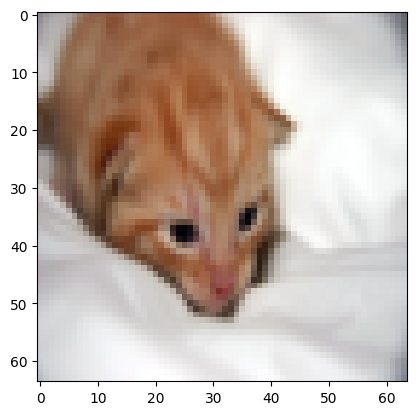

In [4]:
## helper function from `utils.py` ##
show_cat(57, classes, train_y, train_x_orig)

y = [0], it's a 'non-cat' picture.


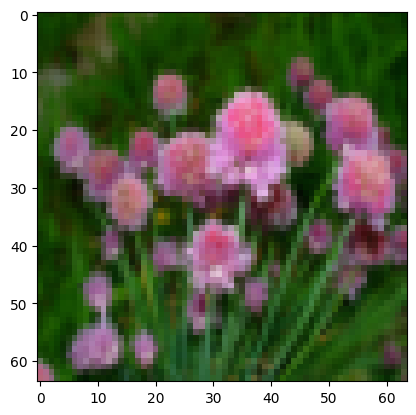

In [5]:
show_cat(21, classes, train_y, train_x_orig)

y = [1], it's a 'cat' picture.


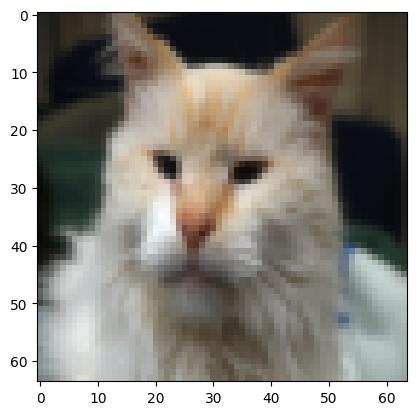

In [6]:
show_cat(27, classes, train_y, train_x_orig)

In [3]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


# Base Model

The following class `BaseModel` consists of the methods common to both the Batch Gradient Descent and Adam optimzed $L$-layer neural network models.

The later subclasses `L_Layer_NN_GradientDescent` and `L_Layer_NN_AdamOptimizer` will inherit from `BaseModel`.

In [1]:
#| code-fold: show

class BaseModel:
    """
    A base class for a neural network model.

    Attributes:
    layer_dims (list): List containing the dimensions of each layer in the network.
    parameters (dict): Dictionary containing the parameters "W1", "b1", ..., "WL", "bL":
                       Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                       bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    def __init__(self, layer_dims):
        """
        Initializes the BaseModel with given layer dimensions and initializes parameters.

        Args:
        layer_dims (list): List containing the dimensions of each layer in the network.
        """
        self.layer_dims = layer_dims

        ### Helper functions imported from `utils.py`###
        ################################################
        self._relu = relu
        self._relu_backward = relu_backward
        self._sigmoid = sigmoid
        self._sigmoid_backward = sigmoid_backward
        ################################################
    
    def _initialise_parameters(self, layer_dims):
        """
        Initializes parameters for the neural network.

        Args:
        layer_dims (list): List containing the dimensions of each layer in the network.

        Returns:
        parameters (dict): Dictionary containing the initialized parameters.
        """
        
        parameters = {}
        L = len(layer_dims)            # number of layers in the network
    
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
            
            assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
            assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
        return parameters

    def _linear_forward(self, A, W, b):
        """
        Implements the linear part of a layer's forward propagation.

        Args:
        A (numpy.ndarray): Activations from previous layer (or input data): (size of previous layer, number of examples)
        W (numpy.ndarray): Weights matrix: (size of current layer, size of previous layer)
        b (numpy.ndarray): Bias vector: (size of the current layer, 1)

        Returns:
        Z (numpy.ndarray): The input of the activation function, also called pre-activation parameter 
        cache (tuple): A tuple containing "A", "W", and "b", stored for computing the backward pass efficiently
        """
        Z = W @ A + b
        cache = (A, W, b)
        
        return Z, cache

    def _linear_activation_forward(self, A_prev, W, b, activation):
        """
        Implements the forward propagation for the LINEAR->ACTIVATION layer

        Args:
        A_prev (numpy.ndarray): Activations from previous layer (or input data): (size of previous layer, number of examples)
        W (numpy.ndarray): Weights matrix: (size of current layer, size of previous layer)
        b (numpy.ndarray): Bias vector: (size of the current layer, 1)
        activation (str): The activation to be used in this layer, either 'sigmoid' or 'relu'

        Returns:
        A (numpy.ndarray): The output of the activation function, also called the post-activation value 
        cache (tuple): A tuple containing "linear_cache" and "activation_cache", stored for computing the backward pass efficiently
        """
        
        if activation == "sigmoid":
            Z, linear_cache = self._linear_forward(A_prev, W, b)
            A, activation_cache = self._sigmoid(Z)
    
        elif activation == "relu":
            Z, linear_cache = self._linear_forward(A_prev, W, b)
            A, activation_cache = self._relu(Z)
    
        cache = (linear_cache, activation_cache)
        return A, cache

    def _L_model_forward(self, X, parameters):
        """
        Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

        Args:
        X (numpy.ndarray): Data array of shape (input size, number of examples)
        parameters (dict): Output of initialize_parameters()

        Returns:
        AL (numpy.ndarray): Activation value from the output (last) layer
        caches (list): List of caches containing every cache of linear_activation_forward()
                       (there are L of them, indexed from 0 to L-1)
        """
    
        caches = []
        A = X
        L = len(parameters) // 2  # number of layers in the neural network
        
        for l in range(1, L):
            A_prev = A 
            A, cache = self._linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], 'relu')
            caches = caches + [cache]
    
        AL, cache = self._linear_activation_forward(A, parameters['W'+str(L)] , parameters['b'+str(L)], 'sigmoid')
        caches = caches + [cache]
              
        return AL, caches

    def _compute_cost(self, AL, Y):
        """
        Compute the binary cross-entropy cost

        Args:
        AL (numpy.ndarray): Probability vector corresponding to label predictions, shape: (1, number of examples)
        Y (numpy.ndarray): True "label" vector shape: (1, number of examples)

        Returns:
        cost: Cross-entropy cost
        """
        m = Y.shape[1]
        epsilon = 1e-6 # For Numerical Stability
        cost = (-1/m) * (np.dot(Y, np.log(AL + epsilon).T) + np.dot(1-Y, np.log(1-AL + epsilon).T))
        cost = np.squeeze(cost)        
        return cost

    def _linear_backward(self, dZ, cache):
        """
        Implement the linear portion of backward propagation for a single layer (layer l)

        Args:
        dZ (numpy.ndarray): Gradient of the cost with respect to the linear output (of current layer l)
        cache (tuple): Tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

        Returns:
        dA_prev (numpy.ndarray): Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW (numpy.ndarray): Gradient of the cost with respect to W (current layer l), same shape as W
        db (numpy.ndarray): Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, W, b = cache
        m = A_prev.shape[1]
    
        dA_prev = W.T @ dZ
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dW = (1/m) * dZ @ A_prev.T
        
        return dA_prev, dW, db

    def _linear_activation_backward(self, dA, cache, activation):
        """
        Implement the backward propagation for the LINEAR->ACTIVATION layer.

        Args:
        dA (numpy.ndarray): Post-activation gradient for current layer l
        cache (tuple): Tuple of values (linear_cache, activation_cache) stored for computing backward propagation efficiently
        activation (str): The activation to be used in this layer, either 'sigmoid' or 'relu'

        Returns:
        dA_prev (numpy.ndarray): Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW (numpy.ndarray): Gradient of the cost with respect to W (current layer l), same shape as W
        db (numpy.ndarray): Gradient of the cost with respect to b (current layer l), same shape as b
        """
        linear_cache, activation_cache = cache
        
        if activation == "relu":
            dZ = self._relu_backward(dA, activation_cache)
            dA_prev, dW, db = self._linear_backward(dZ, linear_cache)
                   
        elif activation == "sigmoid":
            dZ = self._sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = self._linear_backward(dZ, linear_cache)
        
        return dA_prev, dW, db

    def _L_model_backward(self, AL, Y, caches):
        """
        Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

        Args:
        AL (numpy.ndarray): Probability vector, output of the forward propagation (L_model_forward())
        Y (numpy.ndarray): True "label" vector (containing 0 if non-cat, 1 if cat)
        caches (list): List of caches containing every cache of linear_activation_forward() with 'relu'
                       (it's caches[l], for l in range(L-1) i.e l = 0...L-2) and the cache of
                       linear_activation_forward() with 'sigmoid' (it's caches[L-1])

        Returns:
        grads (dict): A dictionary with the gradients
                      grads["dA" + str(l)] = ... 
                      grads["dW" + str(l)] = ...
                      grads["db" + str(l)] = ... 
        """
        grads = {}
        L = len(caches) # the number of layers
        m = AL.shape[1]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # derivative of cost with respect to AL
        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = self._linear_activation_backward(dAL, current_cache, 'sigmoid')
        grads["dA" + str(L-1)] = dA_prev_temp
        grads["dW" + str(L)] = dW_temp
        grads["db" + str(L)] = db_temp
        
        # Loop from l=L-2 to l=0
        for l in reversed(range(L-1)):
            # lth layer: (RELU -> LINEAR) gradients. 
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self._linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu')
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
    
        return grads

    def learning_curve(self):
        """
        Plots the learning curve.
        """
        plot_costs(self.costs, self.learning_rate)  ## helper function from `utils.py` ##


    def predict(self, X, y):
        """
        Predict the output for a given input X and compare it with the true output y.
        The method performs forward propagation, converts probabilities to binary predictions,
        and calculates the accuracy of the predictions.
    
        Parameters:
        X : numpy array
            Input data
        y : numpy array
            True labels
    
        Returns:
        p : numpy array
            Binary predictions for the input data
        """
        m = X.shape[1]
        n = len(self.best_parameters) // 2 
        p = np.zeros((1, m))
    
        # Forward propagation
        probas, _ = self._L_model_forward(X, self.best_parameters)
    
        # Convert probabilities to binary predictions
        p = (probas > 0.5).astype(int)
    
        # Calculate accuracy
        acc = np.mean(p == y) * 100
        print(f"Accuracy: {acc:.2f}%")
    
        return p


# The BGD-Optimized Model

The following class `L_Layer_NN_GradientDescent` inherits from `BaseModel` and represents an artifical neural network with an arbitary number $L$ of layers trained using batch gradient descent (i.e. vanilla gradient descent with minibatch size = training set size).

For more details on vanilla gradient descent see Wikipedia:

> [https://en.wikipedia.org/wiki/Gradient_descent](https://en.wikipedia.org/wiki/Gradient_descent)

and my previous blog post:

> [Logistic Regression with Gradient Descent and L2-Regularization](https://danieljamessmith.github.io/blog/posts/ng1/#gradient-descent)

The number of neurons in each layer are passed into the model via the list `layer_dims`. The $l$-th entry of `layer_dims` represents the number of neurons in the $l$-th layer of the neural network (being careful to remember that Python indexing starts at 0). Thus the number $L$ of layers in the network is implicity passed to the class via `L = len(layer_dims)`.

When creating an instance of the class `L_Layer_NN_GradientDescent` we need also to specify a learning rate $\alpha$. If no learning rate is specified the model defaults to $\alpha = 0.0075$.

In [5]:
#| code-fold: show

class L_Layer_NN_GradientDescent(BaseModel):
    """
    A neural network model with L layers trained using gradient descent.

    Inherits from BaseModel.

    Attributes:
    layer_dims (list): List containing the dimensions of each layer in the network.
    learning_rate (float): The learning rate of the gradient descent update rule.
    """

    def __init__(self, layer_dims, learning_rate=0.0075):
        """
        Initializes the L_Layer_NN_GradientDescent model with given layer dimensions and learning rate.

        Args:
        layer_dims (list): List containing the dimensions of each layer in the network.
        learning_rate (float, optional): The learning rate of the gradient descent update rule. Default is 0.0075.
        """
        super().__init__(layer_dims)
        self.learning_rate = learning_rate

    def _update_parameters(self, parameters, grads):
        """
        Update parameters using gradient descent.

        Args:
        parameters (dict): Python dictionary containing the parameters.
        grads (dict): Python dictionary containing the gradients, output of L_model_backward.

        Returns:
        parameters (dict): Python dictionary containing the updated parameters.
                           parameters["W" + str(l)] = ...
                           parameters["b" + str(l)] = ...
        """
        L = len(parameters) // 2  # number of layers in the neural network
    
        for l in range(L):
            parameters["W" + str(l+1)] -= self.learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] -= self.learning_rate * grads["db" + str(l+1)]
    
        return parameters

    def fit(self, X, Y, num_iterations=1000, print_cost=True):
        """
        Implements an L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

        Args:
        X (numpy.ndarray): Input data, of shape (n_x, number of examples).
        Y (numpy.ndarray): True "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples).
        num_iterations (int, optional): Number of iterations of the optimization loop. Default is 1000.
        print_cost (bool, optional): If True, it prints the cost every 100 steps. Default is True.

        Returns:
        parameters (dict): Parameters learnt by the model. They can then be used to predict.
        """
    
        costs = []
    
        parameters = self._initialise_parameters(self.layer_dims)
    
        for i in range(0, num_iterations):
            AL, caches = self._L_model_forward(X, parameters)
            cost = self._compute_cost(AL, Y)
            grads = self._L_model_backward(AL, Y, caches)
            parameters = self._update_parameters(parameters, grads)
    
            if print_cost and (i % 100 == 0 or i == num_iterations - 1):
                print(f"Cost after iteration {i}: {np.squeeze(cost)}")
            if i % 100 == 0:
                costs.append(cost)
                
        self.best_parameters = parameters
        self.costs = costs


## Fitting BGD Model

We use a 4-layer neural network with the architecture $12288 \rightarrow 20 \rightarrow 7 \rightarrow 5 \rightarrow 1$.

Note that the input layer needs to have $12288$ neurons as our data is $12288$ dimensional: 

$$64\times64\times3=12288$$

In [6]:
### Architecture ###
dims = [12288, 20, 7, 5, 1] #  4-layer model

In [7]:
model_gd = L_Layer_NN_GradientDescent(layer_dims=dims,
                                      learning_rate=0.0075)

In [8]:
model_gd.fit(train_x,
             train_y, 
             num_iterations=2000,
             print_cost=True)

Cost after iteration 0: 0.7062343014430913
Cost after iteration 100: 0.6404381634500909
Cost after iteration 200: 0.6229251672354292
Cost after iteration 300: 0.5600817276725278
Cost after iteration 400: 0.47732634302936927
Cost after iteration 500: 0.4647746569317722
Cost after iteration 600: 0.4156415884654418
Cost after iteration 700: 0.3626064263804877
Cost after iteration 800: 0.30529033046829496
Cost after iteration 900: 0.25001177974445454
Cost after iteration 1000: 0.24070219047020605
Cost after iteration 1100: 0.08646489850870899
Cost after iteration 1200: 0.060508104342182324
Cost after iteration 1300: 0.04040595887122394
Cost after iteration 1400: 0.02855421388486012
Cost after iteration 1500: 0.021288159964999314
Cost after iteration 1600: 0.016496164189856312
Cost after iteration 1700: 0.013195757354987547
Cost after iteration 1800: 0.010832676095288549
Cost after iteration 1900: 0.009090714076649286
Cost after iteration 1999: 0.007753124670288281


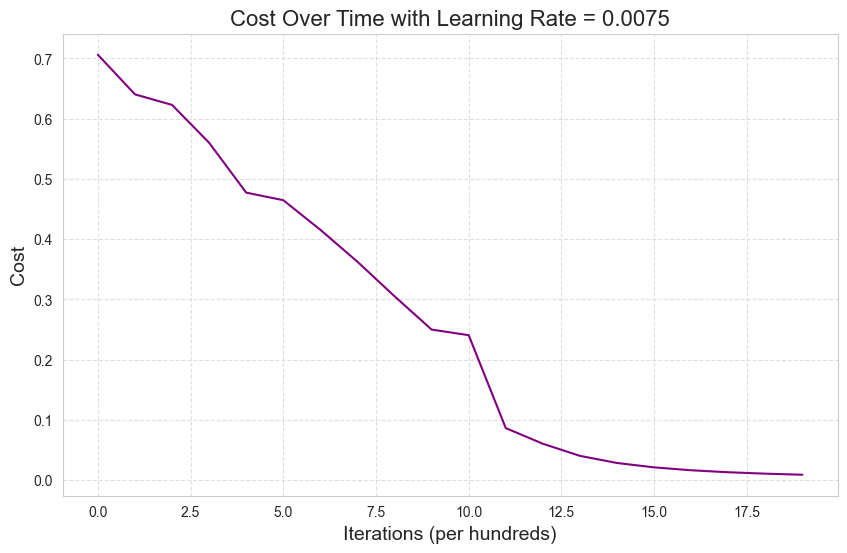

In [9]:
model_gd.learning_curve()

In [10]:
print('Accuracy on training data:\n')
predictions_train = model_gd.predict(train_x, train_y)

Accuracy on training data:

Accuracy: 100.00%


In [11]:
print('Accuracy on test data:\n')
predictions_test = model_gd.predict(test_x, test_y)

Accuracy on test data:

Accuracy: 72.00%


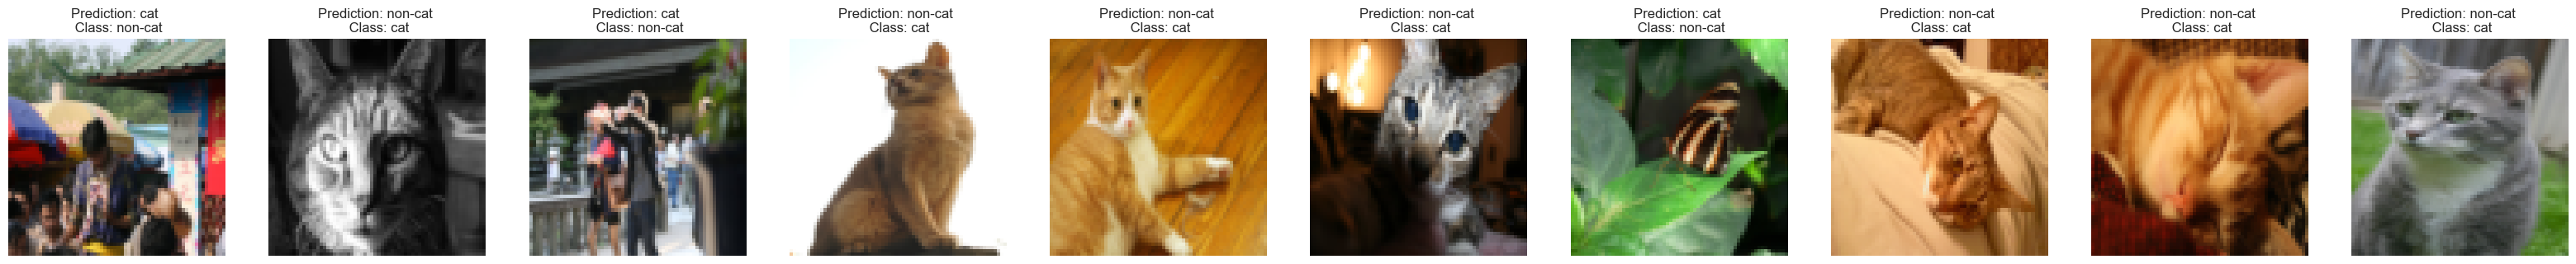

In [12]:
## helper function from `utils.py` ##
print_mislabeled_images(classes, test_x, test_y, predictions_test, number=10)

# The Adam-Optimized Model 

## The Adam Optimizer

The **Adam (Adaptive Moment Estimation) Optimizer** is a popular optimization algorithm used in deep learning models. It combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

Adam's method is computationally efficient and has little memory requirement. It is invariant to diagonal rescale of the gradients, and it is well suited for problems that are large in terms of data and/or parameters. The method is straightforward to implement and has been proven to work well in practice.

The implementation of the Adam optimizer is as follows:

1. **Compute the gradient**: The first step in the process is to compute the gradient of the loss function with respect to each weight in the network. This gradient, $g_t$, is computed using backpropagation.

    $$g_t = \nabla_\theta f_t(\theta)$$

    where $\theta$ denotes the parameters of the model (i.e. the weights and biases of the network).

3. **Update biased first moment estimate**: The first moment estimate, $m_t$, is an exponentially decaying average of past gradients. The decay rate is controlled by the hyperparameter $\beta_1\in [0,1)$. 

    $$m_t = \beta_1 * m_{t-1} + (1 - \beta_1) * g_t$$

4. **Update biased second raw moment estimate**: The second moment estimate, $v_t$, is an exponentially decaying average of past squared gradients. The decay rate is controlled by the hyperparameter $\beta_2\in [0,1)$.

    $$v_t = \beta_2 * v_{t-1} + (1 - \beta_2) * g_t^2$$

5. **Compute bias-corrected estimates**: The first and second moment estimates are biased towards zero in the initial time steps. To correct this bias, we compute the bias-corrected first moment estimate, $\hat{m}_t$, and the bias-corrected second raw moment estimate, $\hat{v}_t$.

    $$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
    $$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$

6. **Update weights**: Finally, we update the weights of our neural network. Each weight, $\theta$, is updated by subtracting a fraction of the bias-corrected first moment estimate. This fraction is determined by the learning rate, $\alpha > 0$. The denominator is the square root of the bias-corrected second raw moment estimate plus a small constant, $\varepsilon << 1$, to prevent division by zero.

    $$\theta \leftarrow \theta - \alpha * \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}$$

The default values of the hyperparameters $\beta_1$, $\beta_2$ and $\varepsilon$ are 

> $\beta_1 = 0.9$
> 
> $\beta_2 = 0.999$
> 
> $\varepsilon = 10^{-8}$

which work well for most problems. 

For more details on the theory and implementation of the Adam optimzer see Wikipedia:

> https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam

In [2]:
#| code-fold: show

class L_Layer_NN_AdamOptimizer(BaseModel):
    """
    A neural network model with L layers trained using Adam optimization.

    Inherits from BaseModel.

    Attributes:
    layer_dims (list): List containing the dimensions of each layer in the network.
    learning_rate (float): The learning rate of the Adam optimization.
    beta1 (float): The exponential decay rate for the first moment estimates.
    beta2 (float): The exponential decay rate for the second moment estimates.
    epsilon (float): A small constant for numerical stability.
    """

    def __init__(self, layer_dims, learning_rate=0.0075, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        Initializes the L_Layer_NN_Adam model with given layer dimensions and learning rate.

        Args:
        layer_dims (list): List containing the dimensions of each layer in the network.
        learning_rate (float, optional): The learning rate of the Adam optimization. Default is 0.0075.
        beta1 (float, optional): The exponential decay rate for the first moment estimates. Default is 0.9.
        beta2 (float, optional): The exponential decay rate for the second moment estimates. Default is 0.999.
        epsilon (float, optional): A small constant for numerical stability. Default is 1e-8.
        """
        super().__init__(layer_dims)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def _initialize_adam(self, parameters):
        """
        Initializes v and s as two python dictionaries with:
                    - keys: "dW1", "db1", ..., "dWL", "dbL" 
                    - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
        
        Arguments:
        parameters -- python dictionary containing your parameters.
                        parameters["W" + str(l)] = Wl
                        parameters["b" + str(l)] = bl
        
        Returns: 
        v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                        v["dW" + str(l)] = ...
                        v["db" + str(l)] = ...
        s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                        s["dW" + str(l)] = ...
                        s["db" + str(l)] = ...

        """
        L = len(self.layer_dims)
        v = {}
        s = {}
        
        for l in range(1, L):
            v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
            v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
            s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
            s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
            
        return v, s

    def _update_parameters_with_adam(self, parameters, grads, v, s, t):
        """
        Update parameters using Adam optimization.

        Args:
        parameters (dict): Python dictionary containing the parameters.
        grads (dict): Python dictionary containing the gradients, output of L_model_backward.
        v (dict): Adam variable, moving average of the first gradient, python dictionary.
        s (dict): Adam variable, moving average of the squared gradient, python dictionary.
        t (int): Adam variable, counts the number of taken steps.

        Returns:
        parameters (dict): Python dictionary containing the updated parameters.
                           parameters["W" + str(l)] = ...
                           parameters["b" + str(l)] = ...
        v (dict): Adam variable, moving average of the first gradient, python dictionary.
        s (dict): Adam variable, moving average of the squared gradient, python dictionary.
        """
        L = len(parameters) // 2                 # number of layers in the neural networks
        v_corrected = {}                         # Initializing first moment estimate, python dictionary
        s_corrected = {}                         # Initializing second moment estimate, python dictionary
        
        # Perform Adam update on all parameters
        for l in range(1, L):
            v["dW" + str(l)] = self.beta1 * v["dW" + str(l)] + (1-self.beta1) * grads["dW" + str(l)] 
            v["db" + str(l)] = self.beta1 * v["db" + str(l)] + (1-self.beta1) * grads["db" + str(l)] 

            v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-self.beta1**t)
            v_corrected["db" + str(l)] = v["db" + str(l)]/(1-self.beta1**t)

            s["dW" + str(l)] = self.beta2*s["dW" + str(l)] + (1-self.beta2)*(grads['dW' + str(l)]*grads['dW' + str(l)])
            s["db" + str(l)] = self.beta2*s["db" + str(l)] + (1-self.beta2)*(grads['db' + str(l)]*grads['db' + str(l)])

            s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1-self.beta2**t)
            s_corrected["db" + str(l)] = s["db" + str(l)]/(1-self.beta2**t)

            parameters["W" + str(l)] -= self.learning_rate * np.divide(v_corrected["dW" + str(l)], np.sqrt(s_corrected["dW" + str(l)]) + self.epsilon)
            parameters["b" + str(l)] -= self.learning_rate * np.divide(v_corrected["db" + str(l)], np.sqrt(s_corrected["db" + str(l)]) + self.epsilon)

        return parameters, v, s

    def fit(self, X, Y, num_iterations=2000, print_cost=True):
        """
        Implements an L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

        Args:
        X (numpy.ndarray): Input data, of shape (n_x, number of examples).
        Y (numpy.ndarray): True "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples).
        num_iterations (int, optional): Number of iterations of the optimization loop. Default is 1000.
        print_cost (bool, optional): If True, it prints the cost every 100 steps. Default is True.

        Returns:
        parameters (dict): Parameters learnt by the model. They can then be used to predict.
        """
        costs = []
        t = 0
        parameters = self._initialise_parameters(self.layer_dims)
        v, s = self._initialize_adam(parameters)
    
        for i in range(0, num_iterations):
            t += 1
            AL, caches = self._L_model_forward(X, parameters)
            cost = self._compute_cost(AL, Y)
            grads = self._L_model_backward(AL, Y, caches)
            parameters, v, s = self._update_parameters_with_adam(parameters, grads, v, s, t)

            if print_cost and (i % 100 == 0 or i == num_iterations - 1):
                print(f"Cost after iteration {i}: {np.squeeze(cost)}")
            if i % 100 == 0:
                costs.append(cost)

        self.best_parameters = parameters
        self.costs = costs


## Fitting Adam Model with default parameters

Again, we use a 4-layer neural network with the architecture $12288 \rightarrow 20 \rightarrow 7 \rightarrow 5 \rightarrow 1$.

In [14]:
### ARCHITECTURE ###
dims = [12288, 20, 7, 5, 1] #  4-layer model

In [15]:
model_adam = L_Layer_NN_AdamOptimizer(dims,
                                      learning_rate=0.0075,
                                      beta1=0.9,
                                      beta2=0.999,
                                      epsilon=1e-08,
)

In [16]:
model_adam.fit(train_x,
               train_y,
               num_iterations=2000,
               print_cost=True)

Cost after iteration 0: 0.677432506089035
Cost after iteration 100: 0.6931451805619453
Cost after iteration 200: 0.6931451805619453
Cost after iteration 300: 0.6931451805619453
Cost after iteration 400: 0.6931451805619453
Cost after iteration 500: 0.6931451805619453
Cost after iteration 600: 0.6931451805619453
Cost after iteration 700: 0.6931451805619453
Cost after iteration 800: 0.6931451805619453
Cost after iteration 900: 0.6931451805619453
Cost after iteration 1000: 0.6931451805619453
Cost after iteration 1100: 0.6931451805619453
Cost after iteration 1200: 0.6931451805619453
Cost after iteration 1300: 0.6931451805619453
Cost after iteration 1400: 0.6931451805619453
Cost after iteration 1500: 0.6931451805619453
Cost after iteration 1600: 0.6931451805619453
Cost after iteration 1700: 0.6931451805619453
Cost after iteration 1800: 0.6931451805619453
Cost after iteration 1900: 0.6931451805619453
Cost after iteration 1999: 0.6931451805619453


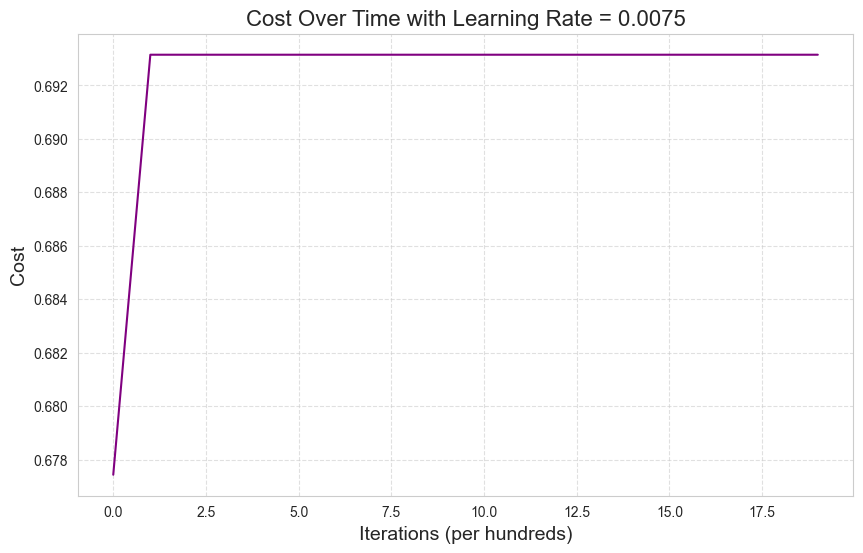

In [17]:
model_adam.learning_curve()

The optimizer seems to be making no progress at all. We certainly do not see convergence in the figure above.

Adam might be getting trapped in a local minimum of the cost function. We can investigate further by reducing the learning rate $\alpha$.

## Reducing `learning_rate`

Repeating with `learning_rate=0.0075` replaced with `learning_rate=0.00075`:

In [20]:
model_adam = L_Layer_NN_AdamOptimizer(dims,
                                      learning_rate=0.00075,
                                      beta1=0.9,
                                      beta2=0.999,
                                      epsilon=1e-08,
)

In [21]:
model_adam.fit(train_x,
               train_y,
               num_iterations=2000,
               print_cost=True)

Cost after iteration 0: 0.7338611614590664
Cost after iteration 100: 0.6193308404218576
Cost after iteration 200: 0.54815296945738
Cost after iteration 300: 0.5215827481065662
Cost after iteration 400: 0.501795625864784
Cost after iteration 500: 0.48482784356842423
Cost after iteration 600: 0.5124480583158955
Cost after iteration 700: 0.4523106134778213
Cost after iteration 800: 0.43338227634083676
Cost after iteration 900: 0.4185369325974699
Cost after iteration 1000: 0.4070917394995416
Cost after iteration 1100: 0.393033861083731
Cost after iteration 1200: 0.38478273430086796
Cost after iteration 1300: 0.3784207769398178
Cost after iteration 1400: 0.3723088150348833
Cost after iteration 1500: 0.36674669812415955
Cost after iteration 1600: 0.36113997520254826
Cost after iteration 1700: 0.35527077809021834
Cost after iteration 1800: 0.34978673486308376
Cost after iteration 1900: 0.3444941711355614
Cost after iteration 1999: 0.33937269527813974


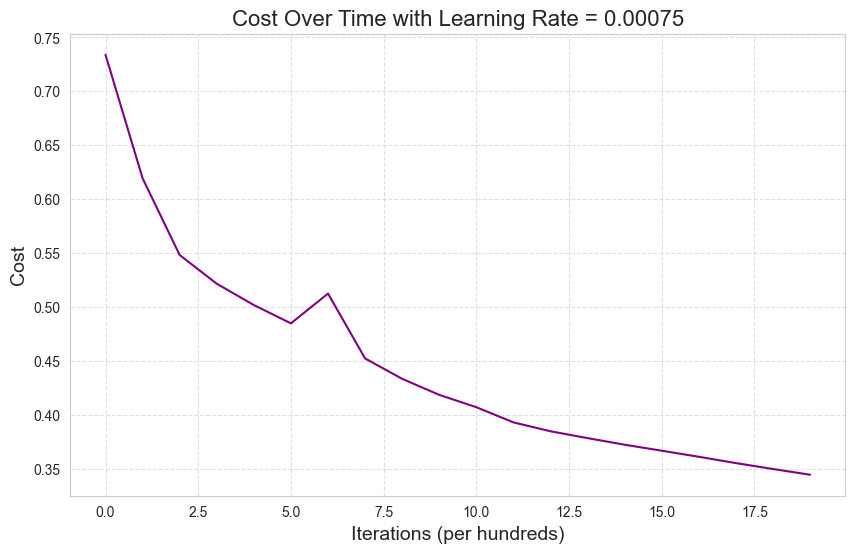

In [22]:
model_adam.learning_curve()

This is definitely an improvement over the first learning curve but still not as good as the results achieved by batch gradient descent.

## Reducing `beta1` and increasing `epsilon`

Replacing `beta1=0.9` with `beta1=0.8`.

Replacing `epsilon=1e-08` with `epsilon=1e-04`:

In [23]:
model_adam = L_Layer_NN_AdamOptimizer(dims,
                                      learning_rate=0.00075,
                                      beta1=0.8,
                                      beta2=0.999,
                                      epsilon=1e-04,
)

In [24]:
model_adam.fit(train_x,
               train_y,
               num_iterations=2000,
               print_cost=True)

Cost after iteration 0: 0.7084378508584687
Cost after iteration 100: 0.292130246866318
Cost after iteration 200: 0.13664169388368827
Cost after iteration 300: 0.07645948653035053
Cost after iteration 400: 0.04742691205157283
Cost after iteration 500: 0.031115162350943176
Cost after iteration 600: 0.02209212192755511
Cost after iteration 700: 0.01641684834702707
Cost after iteration 800: 0.010959383189569771
Cost after iteration 900: 0.007495424042212977
Cost after iteration 1000: 0.006330333559985924
Cost after iteration 1100: 0.005618136476453307
Cost after iteration 1200: 0.005143165972074695
Cost after iteration 1300: 0.004787370371286934
Cost after iteration 1400: 0.004535495041426705
Cost after iteration 1500: 0.0013435492833420732
Cost after iteration 1600: 0.0008856651799834186
Cost after iteration 1700: 0.0007068606565058238
Cost after iteration 1800: 0.0005917661104938714
Cost after iteration 1900: 0.0005080772404285796
Cost after iteration 1999: 0.0004430968047141927


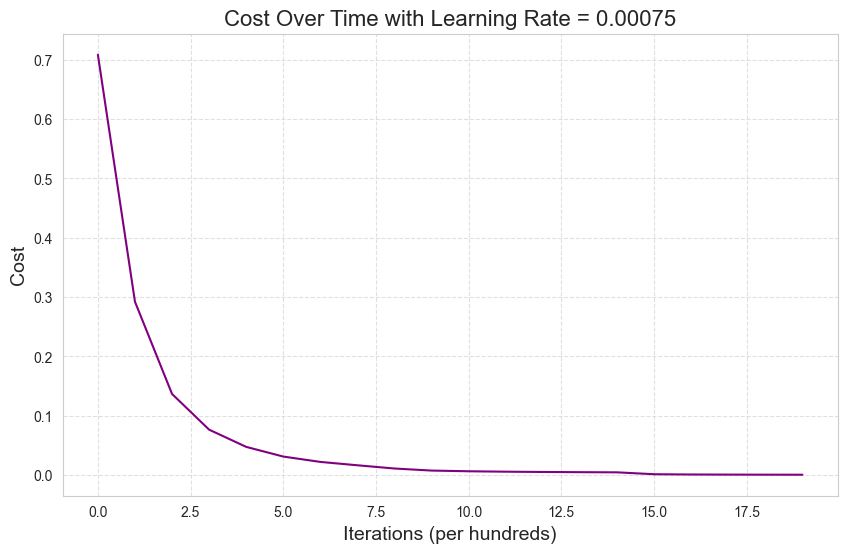

In [25]:
model_adam.learning_curve()

This looks much better. Not only is the Adam optimizer smoothly convering with these choices of hyperparameters but it is doing so much faster than batch gradient descent.

In [26]:
print('Accuracy on training data:\n')
predictions_train = model_adam.predict(train_x, train_y)

Accuracy on training data:

Accuracy: 100.00%


In [27]:
print('Accuracy on test data:\n')
predictions_test = model_adam.predict(test_x, test_y)

Accuracy on test data:

Accuracy: 72.00%


## Reducing `num_iterations` to counteract overfitting

Now that we have Adam smoothy and rapidly converging we can reduce `num_iterations`. The learning curve immediately above suggests that `num_iterations=2000` is unnecessarily large and will surely result in overfitting from training for too long.

Replacing `num_iterations=2000` with `num_iterations=500`:

In [30]:
model_adam = L_Layer_NN_AdamOptimizer(dims,
                                      learning_rate=0.00075,
                                      beta1=0.8,
                                      beta2=0.999,
                                      epsilon=1e-04,
)

In [31]:
model_adam.fit(train_x,
               train_y,
               num_iterations=500,
               print_cost=True)

Cost after iteration 0: 0.6994950488552396
Cost after iteration 100: 0.26011356134545854
Cost after iteration 200: 0.06927856142422689
Cost after iteration 300: 0.02430204158752645
Cost after iteration 400: 0.011715179992492213
Cost after iteration 499: 0.006809646501698239


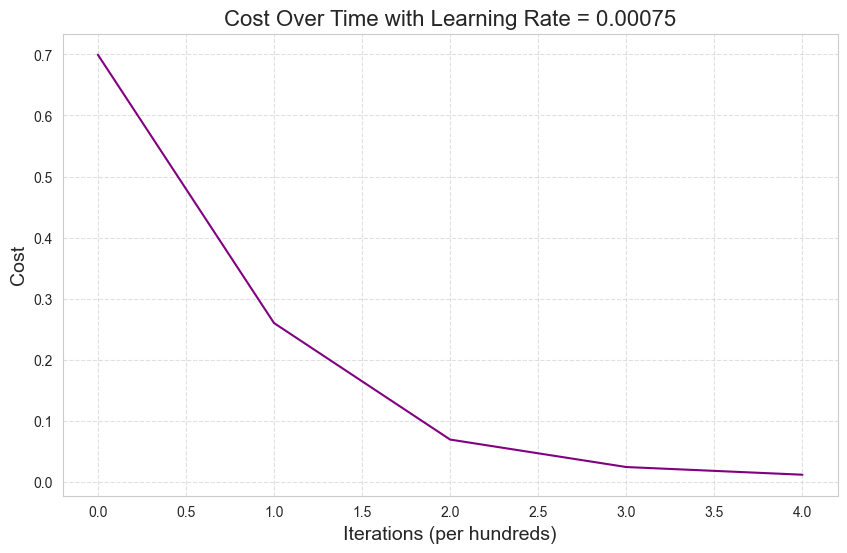

In [32]:
model_adam.learning_curve()

In [33]:
print('Accuracy on training data:\n')
predictions_train = model_adam.predict(train_x, train_y)

Accuracy on training data:

Accuracy: 100.00%


In [34]:
print('Accuracy on test data:\n')
predictions_test = model_adam.predict(test_x, test_y)

Accuracy on test data:

Accuracy: 74.00%


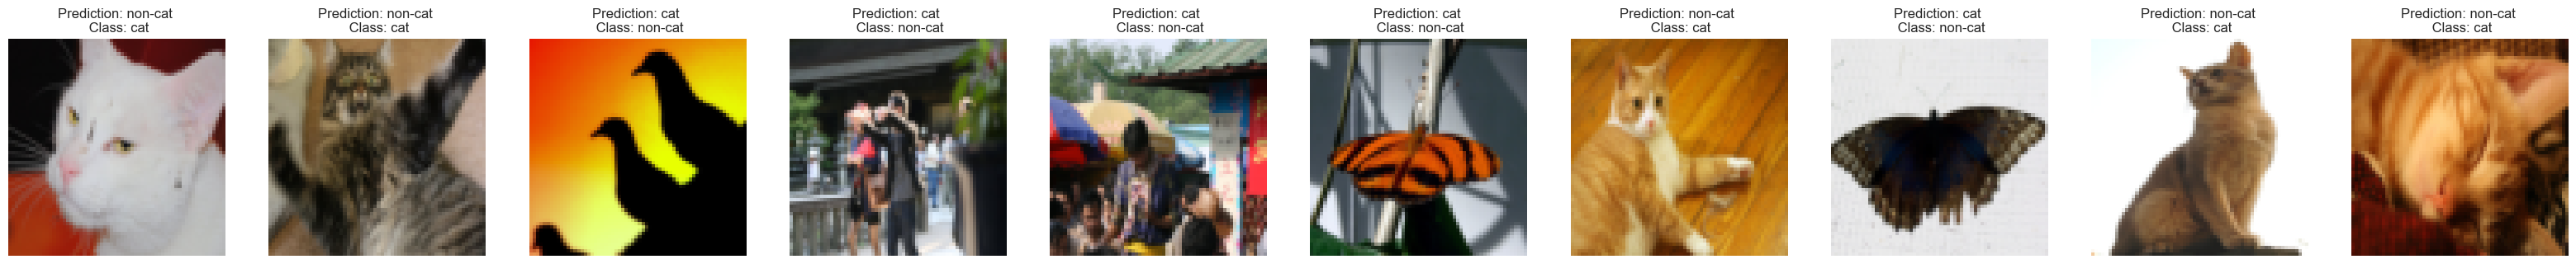

In [35]:
print_mislabeled_images(classes, test_x, test_y, predictions_test, number=10)

> - The models seem to struggle with cats in unusual poses and at unusual scales (i.e. close to the camera).
>
> - They also seem to struggle when cats are a similar colour to their backgrounds.
>
> - We could improve the performance of the model by including more of such images in the training set, using data augmentation or otherwise.
>
> - A convincing theory as for why the model seems to consistently misclassify moths and butterflies as cats is that they have a very similar shape to cat ears. (Credit to Eleanor)

# Remarks and Further Directions

> - [Hand-coding logistic regression](https://danieljamessmith.github.io/blog/posts/ng1/#combining-into-logistic-regression) resulted in a test accuracy of $68\%$ (before regularization and hyperparameter tuning).
>   
> - The BGD-optimized $4$-layer neural network achieved a test accuracy of $72\%$ without any regularization or tuning.
>
> - The Adam-optimzed $4$-layer neural network achieved a test accuracy of $74\%$ without any regularization and tuning only so far as to see convergence.
>
> - Thus the $4$-layer neural network outperformed the $1$-layer neural network (logistic regression). And the $4$-layer neural network optimzed by Adam outperformed the network optimized by batch gradient descent. This is satisfying!
>
> - It would be interesting to see to what degree further increasing the complexity of the network improves results. The classes implemented in this notebook can be readily used with more complex `layer_dims`.
>
> - All the models implemented in this notebook are surely overfitting to the training data to a high degree. I would be interested to learn how to implement regularization techniques such as $L_2$ terms in the cost function and dropout layers in NumPy in order to add them to my classes.
>
> - I performed no significant hyperparameter tuning in this notebook. It would be interesting to see to what degree improvements would continue when tuning parameters such as `beta1` and `beta2` in Adam.
>
> - Adam is normally used with minibatches. Due to the size of the training set (only 209 training examples) implementing minibatches did not seem particularly practicable here. Small minibatch sizes add noise in the optimization process that provides a form of regularization. This regularization might improve the generalisability of the models. I would be interested in extending these classes to allow the inclusion of minibatches and seeing the difference made on a larger dataset.
>
> - I investigated how the learning curves would look when the cost was plotted every iteration, not every 100 iterations. I was unhappy to see that they had significant spikes as in the following plot:
>
>   <img src="img/curve.png" style="width:50%">
>
>   I had hoped to see a smooth, monotonically decreasing learning curve. According to my very brief research some spikes in a plot like this are to be expected, due to the stochastic nature of optimization algorithms such as Adam. Such spikes can also occur due to numerical instabilities in the code, such as when we take the logarithm of a very small number. Adding a small positive value $\varepsilon$ to the logarithms `np.log` in the method `BaseModel._calculate_cost` indeed reduced the severity of these spikes. I would be interested in learning about how else such instabilities are dealt with in common frameworks such as PyTorch and TensorFlow.